In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def read_dataset(fname):
    # 指定第一列作为行索引
    data = pd.read_csv(fname, index_col=0) 
    # 丢弃无用的数据
    data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    # 处理性别数据
    data['Sex'] = (data['Sex'] == 'male').astype('int')
    # 处理登船港口数据
    labels = data['Embarked'].unique().tolist()
    data['Embarked'] = data['Embarked'].apply(lambda n: labels.index(n))
    # 处理缺失数据
    data = data.fillna(0)
    return data

train = read_dataset('datasets/titanic/train.csv')

In [3]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0
2,1,1,0,38.0,1,0,71.2833,1
3,1,3,0,26.0,0,0,7.9250,0
4,1,1,0,35.0,1,0,53.1000,0
5,0,3,1,35.0,0,0,8.0500,0


In [4]:
from sklearn.model_selection import train_test_split

y = train['Survived'].values
X = train.drop(['Survived'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('train dataset: {0}; test dataset: {1}'.format(
    X_train.shape, X_test.shape))

train dataset: (712, 7); test dataset: (179, 7)


In [5]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

DecisionTreeClassifier()

train score: 0.9845505617977528; test score: 0.776536312849162


In [6]:
from sklearn.tree import export_graphviz

with open("titanic.dot", 'w') as f:
    f = export_graphviz(clf, out_file=f)

# 1. 在电脑上安装 graphviz
# 2. 运行 `dot -Tpng titanic.dot -o titanic.png` 
# 3. 在当前目录查看生成的决策树 titanic.png

best param: 3; best score: 0.8044692737430168


<Figure size 1440x864 with 0 Axes>

Text(0.5, 0, 'max depth of decision tree')

Text(0, 0.5, 'score')

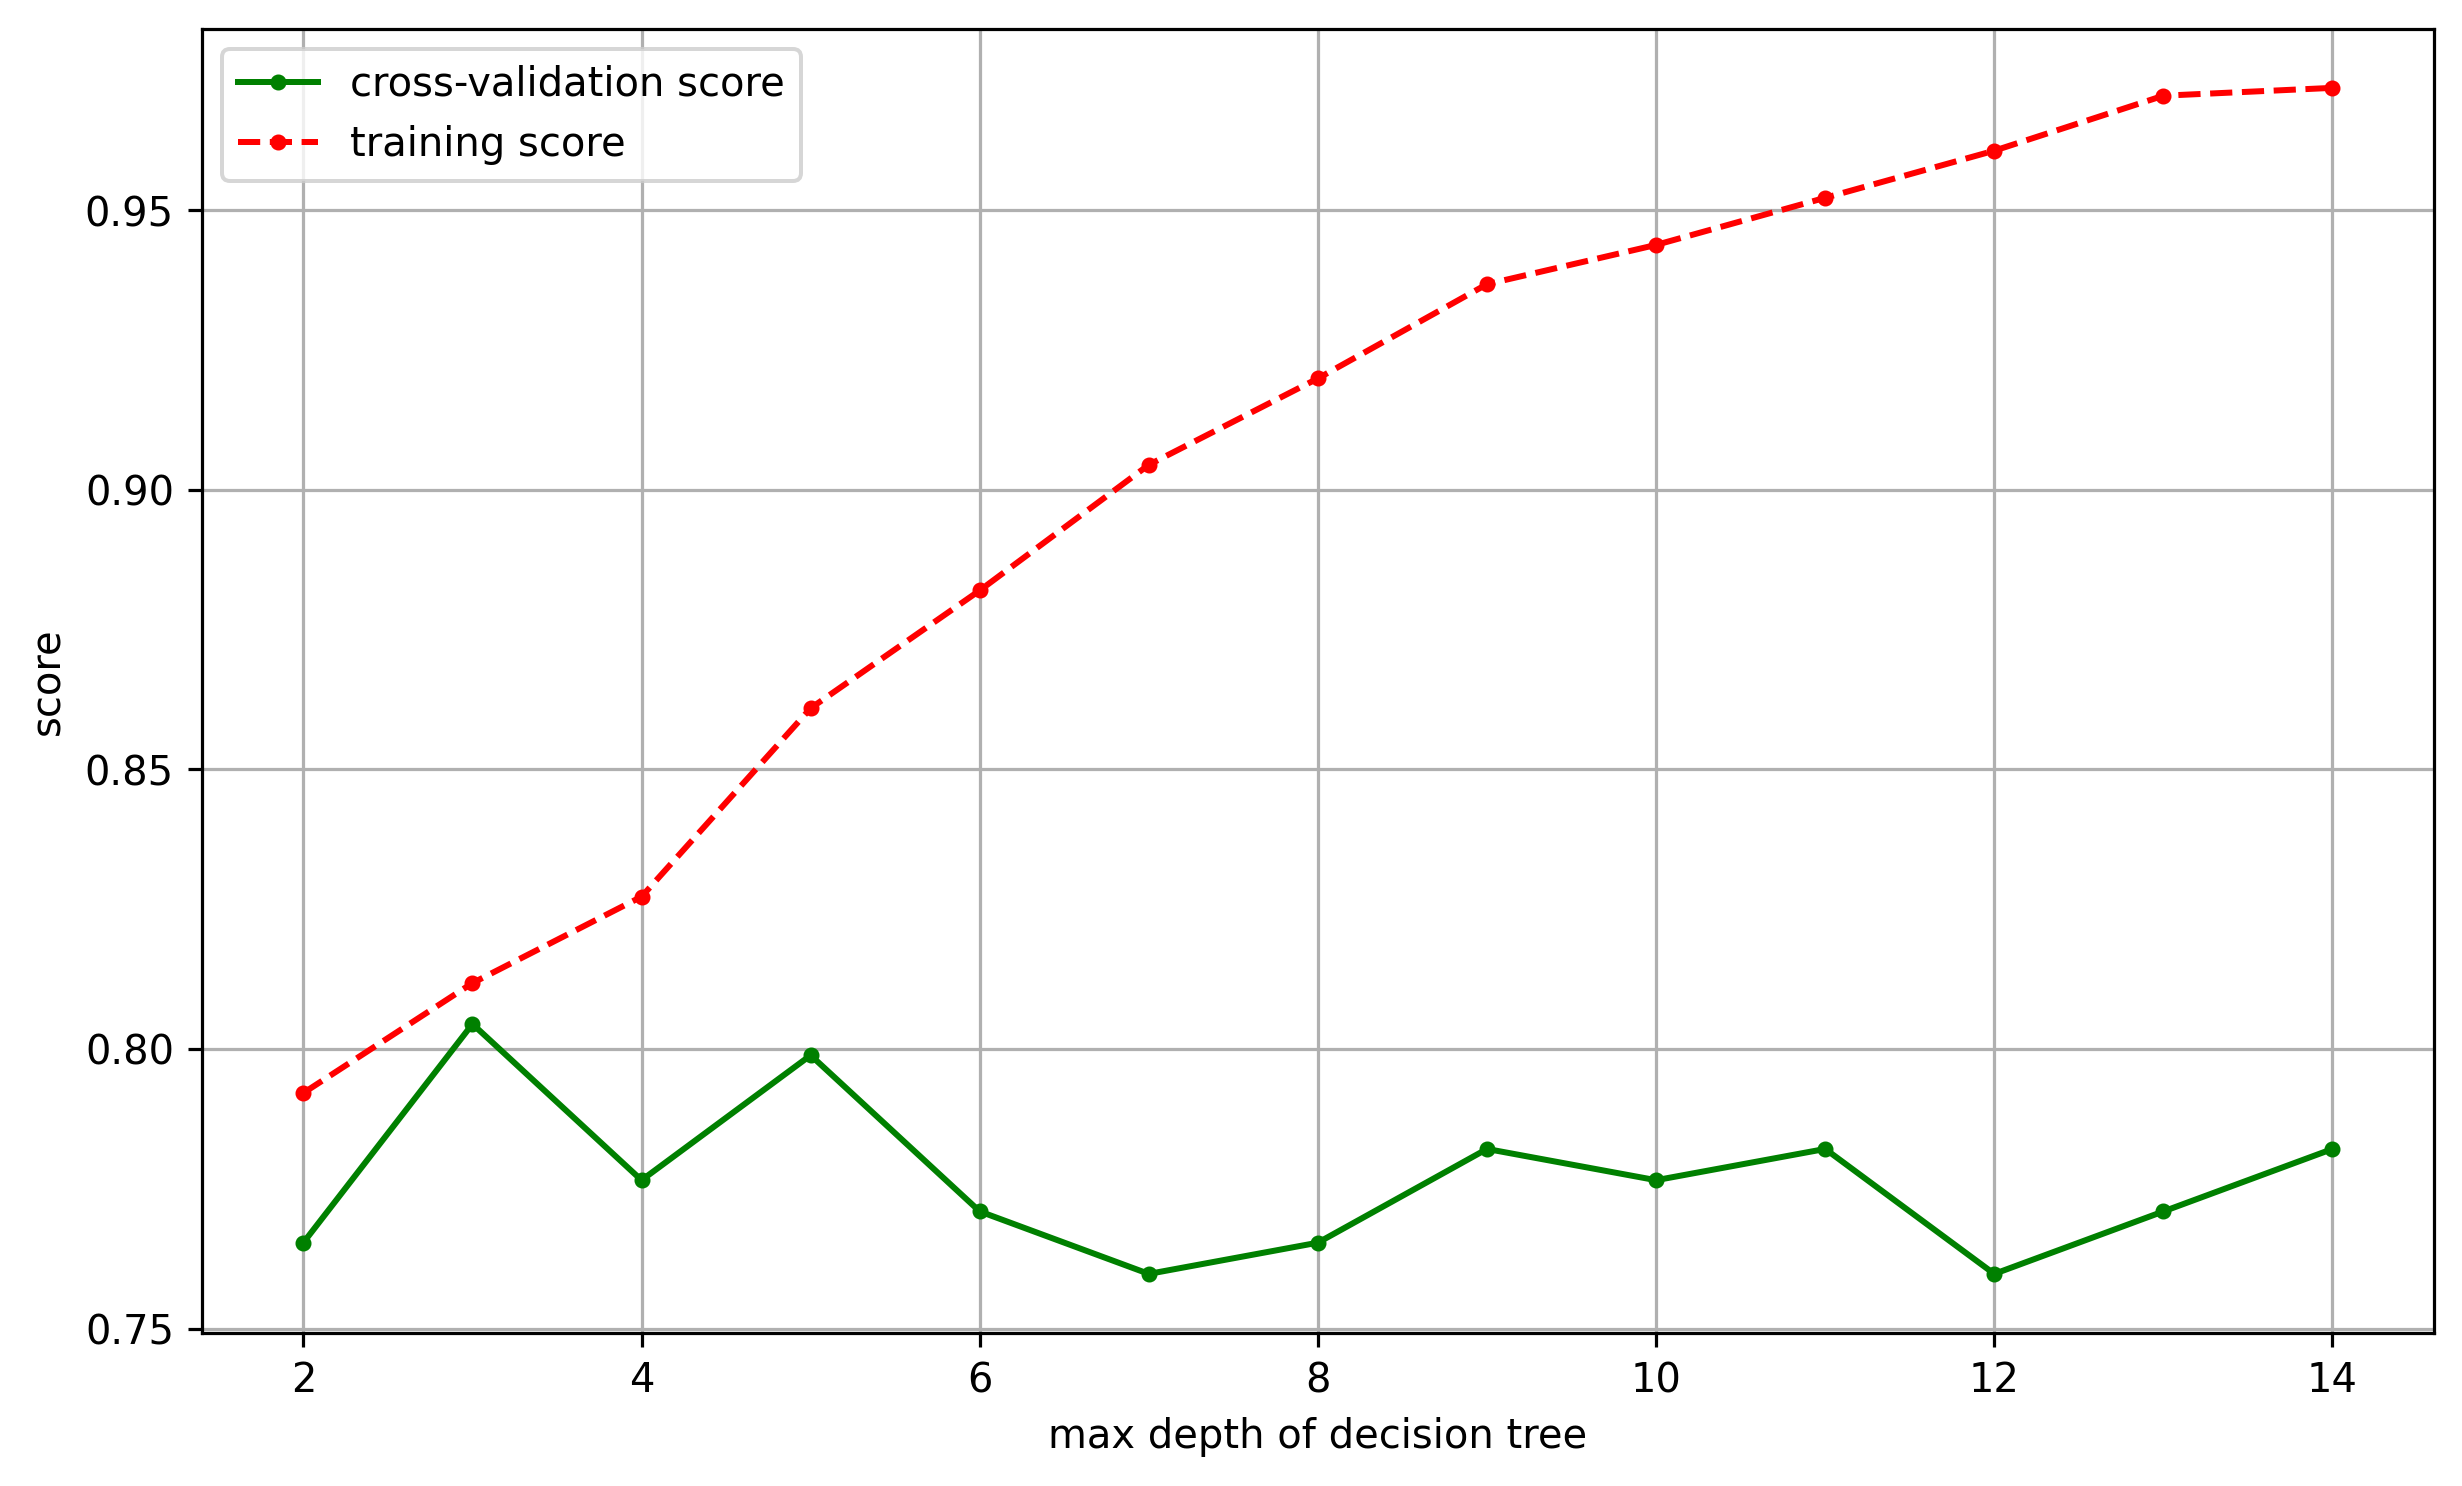

In [7]:
# 参数选择 max_depth
def cv_score(d):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

depths = range(2, 15)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = depths[best_score_index]
print('best param: {0}; best score: {1}'.format(best_param, best_score))

plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.xlabel('max depth of decision tree')
plt.ylabel('score')
plt.plot(depths, cv_scores, '.g-', label='cross-validation score')
plt.plot(depths, tr_scores, '.r--', label='training score')
plt.legend()

best param: 0.004795918367346939; best score: 0.8156424581005587


<Figure size 1440x864 with 0 Axes>

Text(0.5, 0, 'threshold of entropy')

Text(0, 0.5, 'score')

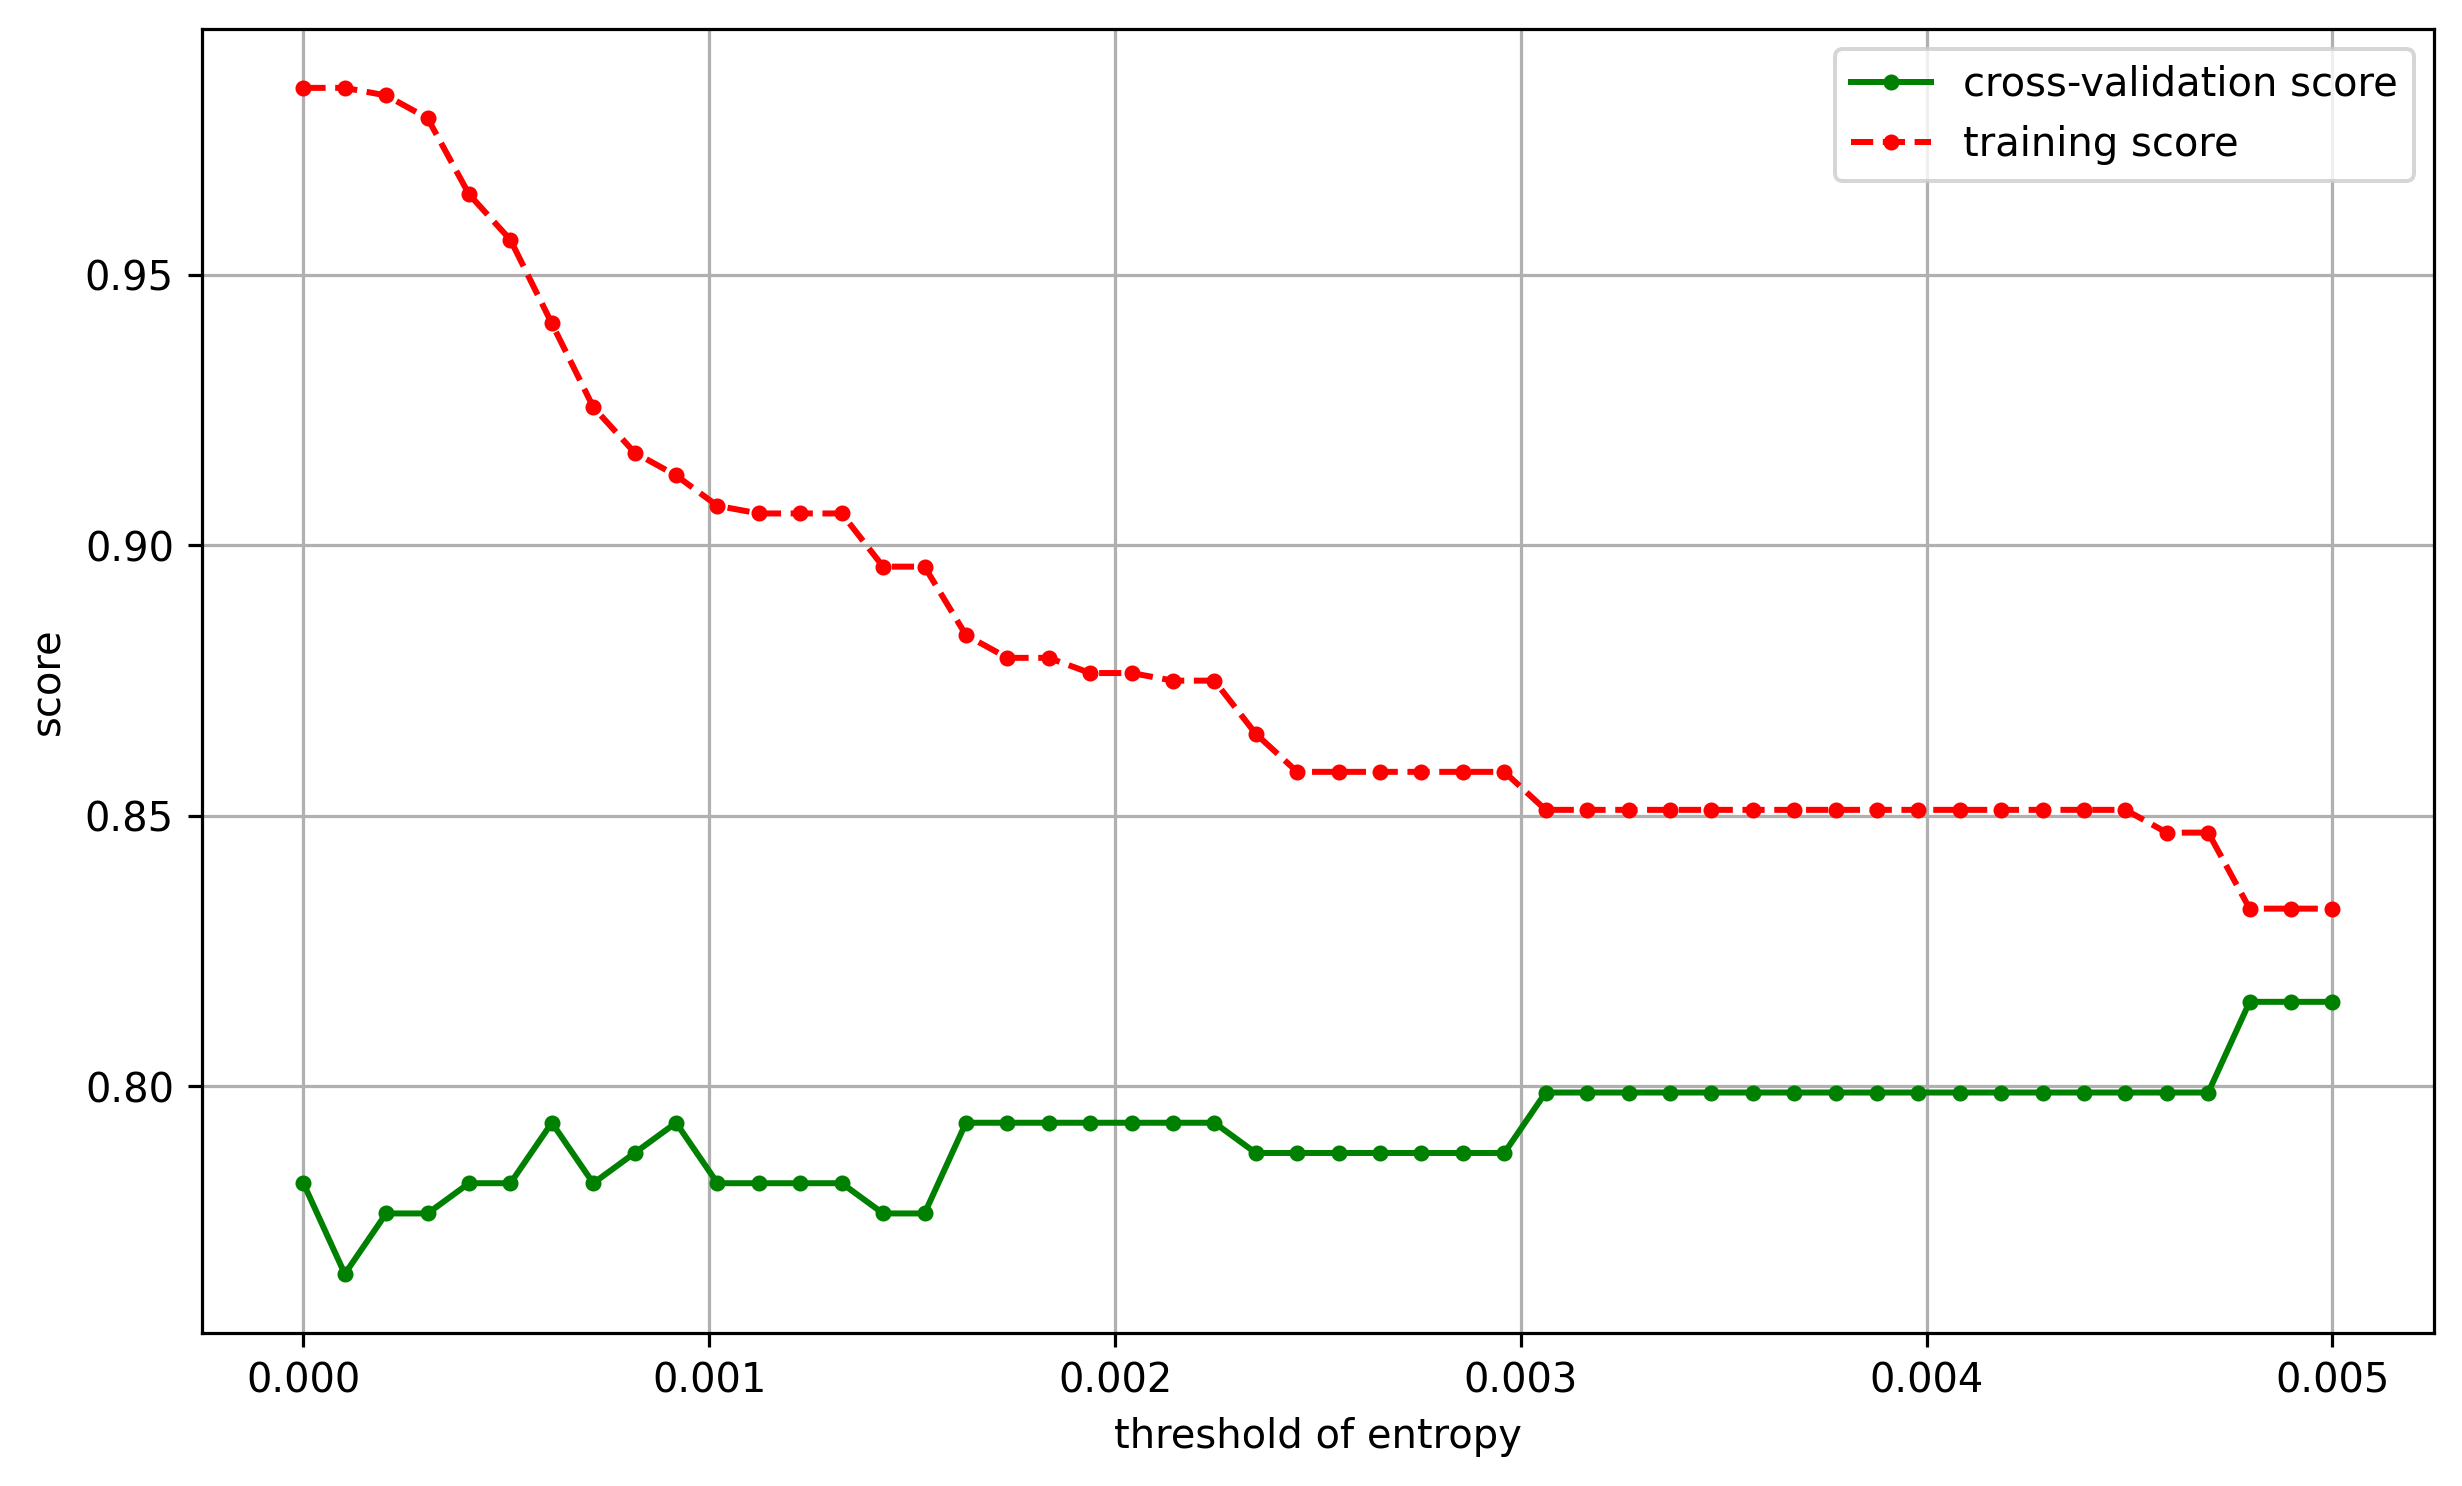

In [8]:
# 训练模型，并计算评分
def cv_score(val):
    clf = DecisionTreeClassifier(criterion='gini', min_impurity_decrease=val)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

# 指定参数范围，分别训练模型，并计算评分
values = np.linspace(0, 0.005, 50)
scores = [cv_score(v) for v in values]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

# 找出评分最高的模型参数
best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = values[best_score_index]
print('best param: {0}; best score: {1}'.format(best_param, best_score))

# 画出模型参数与模型评分的关系
plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.xlabel('threshold of entropy')
plt.ylabel('score')
plt.plot(values, cv_scores, '.g-', label='cross-validation score')
plt.plot(values, tr_scores, '.r--', label='training score')
plt.legend()

In [9]:
def plot_curve(train_sizes, cv_results, xlabel):
    train_scores_mean = cv_results['mean_train_score']
    train_scores_std = cv_results['std_train_score']
    test_scores_mean = cv_results['mean_test_score']
    test_scores_std = cv_results['std_test_score']
    plt.figure(figsize=(10, 6), dpi=144)
    plt.title('parameters turning')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '.--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '.-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'min_impurity_decrease': array([0.        , 0.00010204, 0.00020408, 0.00030612, 0.00040816,
       0.0005102 , 0.00061224, 0.00071429, 0.00081633, 0.00091837,
       0.00102041, 0.00112245, 0.00122449, 0.00132653, 0.00142857,
       0.00153061, 0.00163265, 0.00173469, 0.00183673, 0.00193878,
       0.00204082, 0.00214286, 0.0022449 , 0.00234694, 0.00244898,
       0.00255102, 0.00265306, 0.0027551 , 0.00285714, 0.00295918,
       0.00306122, 0.00316327, 0.00326531, 0.00336735, 0.00346939,
       0.00357143, 0.00367347, 0.00377551, 0.00387755, 0.00397959,
       0.00408163, 0.00418367, 0.00428571, 0.00438776, 0.0044898 ,
       0.00459184, 0.00469388, 0.00479592, 0.00489796, 0.005     ])},
             return_train_score=True)

best param: {'min_impurity_decrease': 0.0009183673469387756}
best score: 0.8103383340656581


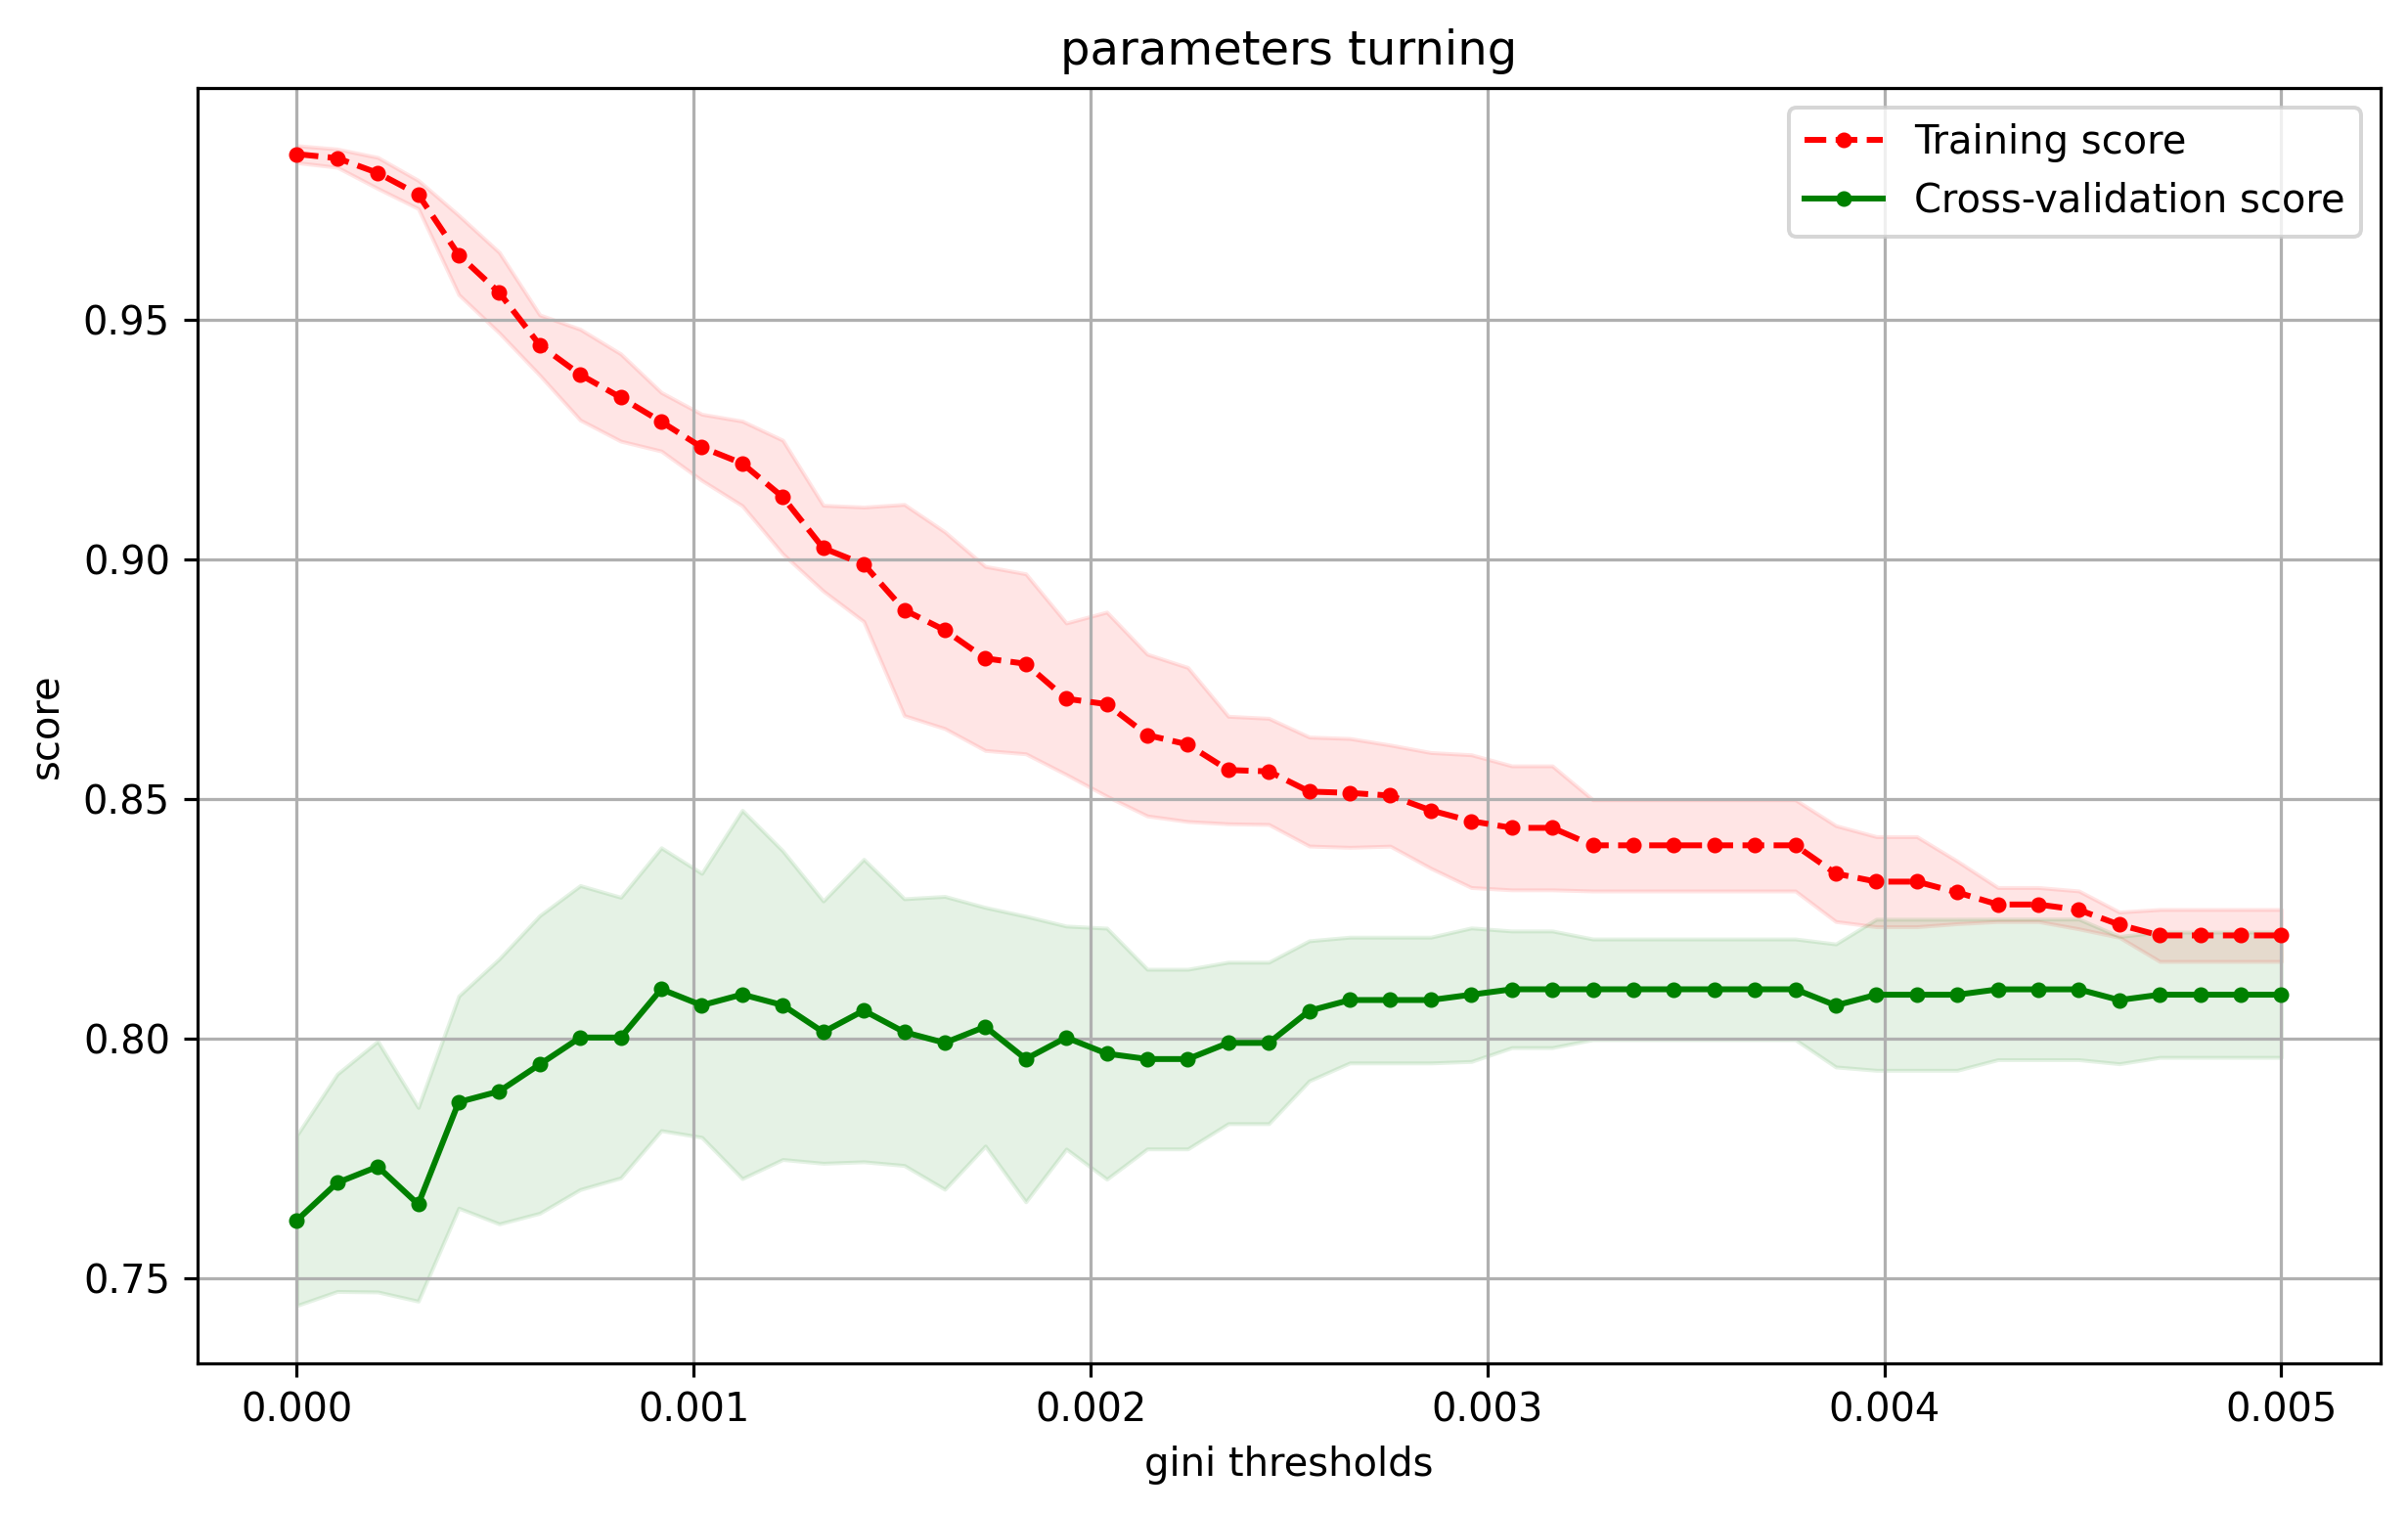

In [10]:
from sklearn.model_selection import GridSearchCV

thresholds = np.linspace(0, 0.005, 50)
# Set the parameters by cross-validation
param_grid = {'min_impurity_decrease': thresholds}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)
clf.fit(X, y)
print("best param: {0}\nbest score: {1}".format(clf.best_params_, 
                                                clf.best_score_))

plot_curve(thresholds, clf.cv_results_, xlabel='gini thresholds')

In [11]:
from sklearn.model_selection import GridSearchCV

entropy_thresholds = np.linspace(0, 0.01, 50)
gini_thresholds = np.linspace(0, 0.005, 50)

# Set the parameters by cross-validation
param_grid = [{'criterion': ['entropy'], 
               'min_impurity_decrease': entropy_thresholds},
              {'criterion': ['gini'], 
               'min_impurity_decrease': gini_thresholds},
              {'max_depth': range(2, 10)},
              {'min_samples_split': range(2, 30, 2)}]

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)
clf.fit(X, y)
print("best param: {0}\nbest score: {1}".format(clf.best_params_, 
                                                clf.best_score_))

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['entropy'],
                          'min_impurity_decrease': array([0.        , 0.00020408, 0.00040816, 0.00061224, 0.00081633,
       0.00102041, 0.00122449, 0.00142857, 0.00163265, 0.00183673,
       0.00204082, 0.0022449 , 0.00244898, 0.00265306, 0.00285714,
       0.00306122, 0.00326531, 0.00346939, 0.00367347, 0.00387755,
       0.00408163, 0.00428...
       0.00255102, 0.00265306, 0.0027551 , 0.00285714, 0.00295918,
       0.00306122, 0.00316327, 0.00326531, 0.00336735, 0.00346939,
       0.00357143, 0.00367347, 0.00377551, 0.00387755, 0.00397959,
       0.00408163, 0.00418367, 0.00428571, 0.00438776, 0.0044898 ,
       0.00459184, 0.00469388, 0.00479592, 0.00489796, 0.005     ])},
                         {'max_depth': range(2, 10)},
                         {'min_samples_split': range(2, 30, 2)}],
             return_train_score=True)

best param: {'criterion': 'entropy', 'min_impurity_decrease': 0.002857142857142857}
best score: 0.826062394074446


## 生成决策树图形

In [12]:
clf = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.002857142857142857)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

# 导出 titanic.dot 文件
with open("titanic.dot", 'w') as f:
    f = export_graphviz(clf, out_file=f)

# 1. 在电脑上安装 graphviz
# 2. 运行 `dot -Tpng titanic.dot -o titanic.png` 
# 3. 在当前目录查看生成的决策树 titanic.png

DecisionTreeClassifier(criterion='entropy',
                       min_impurity_decrease=0.002857142857142857)

train score: 0.9185393258426966; test score: 0.7821229050279329
